In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from os import environ

import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.catalog import TileCatalog, convert_mag_to_nmgy, convert_nmgy_to_mag

In [9]:
with initialize(config_path="./conf", version_base=None):
    cfg = compose("config")

data_path = "/data/scratch/aakash/multi_field"
cached_dataset = instantiate(cfg.cached_simulator, cached_data_path=data_path, splits="0:0/0:0/90:100")
cached_dataset.setup(stage="test")
test_size = len(cached_dataset.test_dataset)

In [ ]:
all_mags = []
for batch in tqdm(cached_dataset.test_dataloader(), desc="Getting fluxes"):
    tile_cat = TileCatalog(batch["tile_catalog"])
    mags = tile_cat.on_magnitudes(zero_point=1)[..., 2]
    mags = torch.masked_select(mags, tile_cat.is_on_mask * (mags < 22))
    all_mags += mags.tolist()
print(len(all_mags))

In [11]:
qs = torch.linspace(0, 1, 11)
print_qs = "  ".join([f"{q:<02.3f}" for q in qs])
print(f"{'Quantiles':<12s}{print_qs}\n------------")

mag_quantiles = torch.quantile(torch.tensor(all_mags), qs)
print_qt = ", ".join([f"{qt:<2.3f}" for qt in mag_quantiles])
print(f"{'mags':<12s}{print_qt}")

Quantiles   0.000  0.100  0.200  0.300  0.400  0.500  0.600  0.700  0.800  0.900  1.000
------------
mags        7.868, 17.777, 19.101, 19.781, 20.258, 20.625, 20.940, 21.227, 21.495, 21.746, 22.000


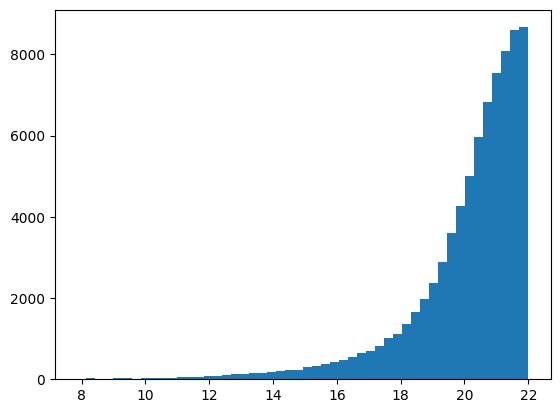

In [12]:
plt.hist(all_mags, bins=50);